# Reconocimiento Facial con Machine Learning para Seguridad

En este proyecto se desarrolla un sistema de reconocimiento facial basado en modelos de *machine learning*, cuyo objetivo es identificar personas autorizadas en un entorno de seguridad utilizando cámaras que capturan imágenes en tiempo real. El sistema tomará los frames capturados por las cámaras de vigilancia y los procesará mediante un algoritmo de clasificación que determina si la persona detectada pertenece al conjunto de individuos autorizados o no.

Adicionalmente, se busca extender el análisis para identificar el género de la persona, con el propósito de enriquecer la información capturada por el sistema de seguridad. Esta característica puede ser utilizada como una capa adicional de validación o para realizar estadísticas de acceso por género, según las necesidades del sistema.

## Dataset Utilizado: Labeled Faces in the Wild (LFW)

Para entrenar el modelo se utilizará el dataset **Labeled Faces in the Wild (LFW)**, una base de datos ampliamente utilizada para el estudio del reconocimiento facial en condiciones no controladas (*in the wild*). Este conjunto fue creado y es mantenido por investigadores de la Universidad de Massachusetts, Amherst.

El dataset contiene un total de **13,233 imágenes** de rostros de **5,749 personas**, detectadas y centradas utilizando el detector de rostros de Viola-Jones. Las imágenes fueron recolectadas de la web, y representan variaciones reales de expresión facial, iluminación, pose, edad y fondo.

De las personas incluidas, **1,680** tienen dos o más imágenes distintas en el conjunto, lo cual permite realizar tareas de entrenamiento y validación más efectivas para problemas de clasificación facial.

Las imágenes están disponibles en color y tienen un tamaño de **250x250 píxeles**. Cada una viene etiquetada con el nombre de la persona, aunque el dataset **no incluye información de género**, por lo que será necesario añadir esta información manualmente o mediante alguna fuente auxiliar para tareas de clasificación de género.

Este notebook se basa en el ejemplo oficial de Scikit-learn: [Face recognition example](https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html), al cual se le añaden mejoras y adaptaciones para cumplir con los objetivos del sistema de seguridad.

### Acceso al Dataset

El dataset puede ser accedido de dos formas. Ya sea directamente desde **scikit-learn**, utilizando la función:

  ```python
  from sklearn.datasets import fetch_lfw_people
  lfw_people = fetch_lfw_people()
  ```

Esta opción permite cargar automáticamente las imágenes y etiquetas con un formato listo para usar en modelos de aprendizaje automático.

O bien puede descargarse desde Kaggle, en el siguiente enlace: https://kaggle.com/datasets/jessicali9530/lfw-dataset

Esta versión contiene las imágenes originales organizadas en carpetas por nombre, útil para procesamiento personalizado o entrenamiento con redes neuronales convolucionales más complejas.

# Reconocimiento Facial con Machine Learning para Seguridad

En este proyecto se desarrolla un sistema de **reconocimiento facial** basado en modelos de *machine learning*, cuyo objetivo es identificar **personas autorizadas** en un entorno de seguridad utilizando **cámaras de videovigilancia** que capturan imágenes en tiempo real.

El sistema esta pensado para procesar cada frame capturado por las cámaras y mediante un algoritmo de **clasificación de rostros**, determinando si la persona detectada pertenece al grupo de individuos autorizados o no.

Adicionalmente, se busca extender el análisis para **identificar el género** de la persona, enriqueciendo así la información registrada por el sistema. Esta característica puede utilizarse como:
- Capa adicional de validación de identidad,
- Generación de estadísticas de acceso,
- O implementación de políticas específicas basadas en demografía.

## Objetivo

- Desarrollar un sistema de **identificación facial automática** para controlar el acceso a zonas seguras.
- Clasificar los rostros capturados no solo por identidad, sino también por **género**.
- Crear un pipeline replicable que pueda escalarse o adaptarse a otros sistemas de videovigilancia.

## Alcance del Proyecto

- Entrenamiento de modelos de reconocimiento facial supervisado.
- Evaluación de métricas de desempeño (accuracy, precision, recall).

## Uso Comercial

Este tipo de tecnología es actualmente utilizada en el mercado por empresas como:
- **Verisure**: Sistemas de alarma con reconocimiento facial para control de acceso y activación automática.
- **ADT**: Soluciones de videovigilancia avanzada que incorporan tecnologías de identificación de personas.

## Dataset Utilizado: Labeled Faces in the Wild (LFW)

Para entrenar el modelo se utilizará el dataset **Labeled Faces in the Wild (LFW)**, una base de datos ampliamente utilizada para el estudio de técnicas de reconocimiento facial en condiciones reales (*in the wild*).

Características principales del dataset:

- **Número total de imágenes**: 13,233 rostros.
- **Número de personas**: 5,749 individuos únicos.
- **Personas con 2 o más imágenes**: 1,680 personas.
- **Tamaño original de las imágenes**: 250 × 250 píxeles (ajustable).
- **Fuente de imágenes**: Fotografías reales recolectadas de internet.
- **Detección de rostros**: Utiliza el detector de Viola-Jones para centrar las caras.
- **Etiquetas**: Cada imagen está etiquetada con el nombre de la persona correspondiente.

> **Nota**: El dataset **no incluye información de género**; esta deberá ser añadida manualmente si se desea realizar una clasificación de género.

---

### Acceso al Dataset

El dataset puede ser accedido de dos maneras:

1. Desde `scikit-learn` (recomendado para prototipos)

    ```python
    from sklearn.datasets import fetch_lfw_people
    lfw_people = fetch_lfw_people()
    ```
    Esto descarga y organiza automáticamente las imágenes en un formato adecuado para modelos de machine learning.

2. Desde Kaggle

    Se puede descargar la versión completa del dataset desde el siguiente enlace:

    👉 [Dataset LFW en Kaggle](https://www.kaggle.com/datasets/jessicali9530/lfw-dataset)

    Esta versión organiza las imágenes en carpetas por nombre de persona, lo que facilita su uso para arquitecturas más complejas como **redes neuronales convolucionales (CNNs)**.

### Basado en ejemplo oficial

Este proyecto se inspira en el ejemplo de reconocimiento facial disponible en la documentación de **scikit-learn**:

👉 [Face recognition example (Scikit-learn)](https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html)

Con mejoras, adaptaciones y extensión hacia la **clasificación de género** y aplicación en **contextos reales de seguridad**.

Para este trabajo se tomarán los datos extraidos directamente desde la librería, ya que vienen preparados para su uso.

In [ ]:
from sklearn.datasets import fetch_lfw_people

# Cargar el dataset (personas con al menos 70 imágenes para mantener equilibrio en las clases)
lfw_people = fetch_lfw_people()

## EDA: Exploratory Data Analysis

El primer paso a llevar a cabo es explorar los datos provenientes del dataset para determinar qué tipo de información posee. Dado que el dataset está pensado para entrenar modelos de clasificación o *clustering*, no posee algunos de los métodos más comunes de analisis preliminar de datos, tales como *head()*, *info()* o *describe()*.

Por lo tanto, estaremos tomando la [documentación oficial](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html) de `fetch_lfw_people` de scikit-learn como referencia. La misma describe el dataset, los datos que posee y el formato de los mismos.

### Descripción del Dataset

El dataset **Labeled Faces in the Wild (LFW)** es una colección de imágenes de rostros diseñada para el estudio del reconocimiento facial en condiciones no controladas. Cuando se carga utilizando `fetch_lfw_people`, el dataset es devuelto como un objeto tipo **Bunch**, similar a un diccionario, que contiene los siguientes atributos:

| Atributo | Forma | Descripción |
|:---------|:------|:------------|
| **`data`** | `(13233, 2914)` | Matriz donde cada fila representa una imagen de rostro aplanada (flattened). Cada imagen original es de tamaño `62 × 47` píxeles. Cambiar `resize` o `slice_` afecta esta dimensión. |
| **`images`** | `(13233, 62, 47)` | Array de imágenes originales. Cada entrada corresponde a un rostro asociado a una de las 5749 personas del dataset. |
| **`target`** | `(13233,)` | Array de etiquetas asociadas a cada imagen. Los valores de `target` son enteros en el rango `[0, 5748]`, representando el ID de cada persona. |
| **`target_names`** | `(5749,)` | Array de strings con los nombres de todas las personas en el dataset. La posición en este array corresponde al ID utilizado en `target`. |
| **`DESCR`** | `str` | Descripción completa del dataset LFW. |

### Salida alternativa (`return_X_y=True`)

Si se establece `return_X_y=True` al cargar el dataset, se devuelve una **tupla** `(data, target)`:

- **`data`**: Matriz 2D de tamaño `(n_samples, n_features)`, donde cada fila representa una muestra (imagen aplanada).
- **`target`**: Array de tamaño `(n_samples,)`, conteniendo las etiquetas asociadas a cada imagen.

### Exploración del Formato

Para verificar el formato de los datos, se tomará el dataset ya descargado y se extraerán los principales sets de datos, guardandolos en variables dentro del *script*.

In [16]:
import numpy as np

# Extraer las dimensiones principales del dataset:
# - n_samples: cantidad total de imágenes disponibles
# - h, w: altura y ancho de cada imagen en píxeles
n_samples, h, w = lfw_people.images.shape

# Obtener la matriz de datos:
# Cada fila de X representa una imagen aplanada en un vector de características
X = lfw_people.data      

# Obtener las etiquetas:
# Cada elemento de y es un índice numérico que representa a una persona
y = lfw_people.target    

# Obtener los nombres de las personas:
# target_names es un arreglo que contiene el nombre real asociado a cada índice
target_names = lfw_people.target_names

# Calcular el número de clases únicas (personas distintas) en el dataset
n_classes = target_names.shape[0]

# Mostrar información básica sobre el dataset
print(f"Número de imágenes: {n_samples}")
print(f"Dimensiones de cada imagen: {h} x {w}")
print(f"Número de clases (personas): {n_classes}")
print(f"Personas en el dataset: {target_names}")

Número de imágenes: 13233
Dimensiones de cada imagen: 62 x 47
Número de clases (personas): 5749
Personas en el dataset: ['AJ Cook' 'AJ Lamas' 'Aaron Eckhart' ... 'Zumrati Juma' 'Zurab Tsereteli'
 'Zydrunas Ilgauskas']


Para entender un poco mejor el dataset, vamos a imprimir algunas de las imagenes junto con el nombre del rotro que se encuentra en la misma.

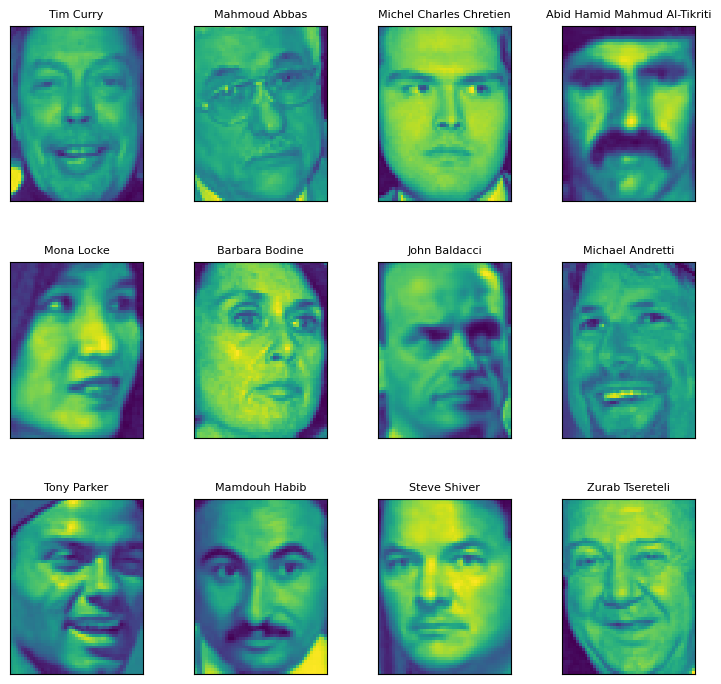

In [21]:
import matplotlib.pyplot as plt

# Función para visualizar una galería de imágenes
# images: conjunto de imágenes a mostrar
# titles: títulos asociados a cada imagen (nombre de la persona)
# h, w: dimensiones (altura, ancho) de cada imagen
# n_row, n_col: cantidad de filas y columnas en la grilla de visualización
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))  # Definir tamaño de la figura
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)  # Espaciado entre imágenes
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)  # Crear cada subgráfico
        plt.imshow(images[i], interpolation='nearest')  # Mostrar imagen
        plt.title(titles[i], size=8)  # Mostrar título (nombre reducido)
        plt.xticks(())  # Quitar marcas de eje x
        plt.yticks(())  # Quitar marcas de eje y

# Generar títulos con los nombres de las personas
titles = [target_names[y[i]] for i in range(12)]

# Llamar a la función para mostrar las primeras 12 imágenes
plot_gallery(lfw_people.images, titles, h, w)

# Mostrar la galería de imágenes
plt.show()


Algo importante a notar, es que el dataset está armado como si fuera una base de datos relacional. Es decir, cada imagen posee un *label* numérico que se corresponde al ID del nombre de una persona dentro del dataset. Esto se debe a que si bien hay 13233 imágenes, sólo son 5749 personas, por lo que sus IDs van a estar repetidos más de una vez dentro del conjunto de datos *y*. Dentro del conjunto de datos *target_names* tenemos la relación entre cada ID y su respectivo nombre.

Para cumplir con el objetivo de clasificar a las personas por genero, se deben generar los labels de género de cada uno de estas personas y asociarlas a cada uno de estas imágenes.

In [22]:
import pandas as pd

# Crear un DataFrame solo con los nombres únicos
target_names_df = pd.DataFrame({
    'Label_ID': range(len(target_names)),  # ID numérico (posición en el array)
    'Label_Name': target_names             # Nombre de la persona
})

# Guardar el DataFrame en un archivo CSV
target_names_df.to_csv('lfw_target_names.csv', index=False)

print("Archivo 'lfw_target_names.csv' creado exitosamente.")


Archivo 'lfw_target_names.csv' creado exitosamente.
